# Model Training
We aim to use the following models:

1. Decision Trees 
2. Random Forest
3. Neural Nets
4. Pre-trained Transformers 


In [1]:
# Standard
import pandas as pd
import numpy as np 

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# tf and keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display

import warnings
warnings.filterwarnings("ignore")

/Users/lucymherr/miniforge3/envs/w207_final/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


# Load and prepare data

In [2]:
# Load train file
train_file =  'split_train_clean.csv' #'mids-207-final-project-summer23-Rueda-Sambrailo-Herr-Liu-Kuehl/split_train_clean.csv' 
train = pd.read_csv(train_file)

# Load test file
test_file = 'split_test_clean.csv' #'mids-207-final-project-summer23-Rueda-Sambrailo-Herr-Liu-Kuehl/split_test_clean.csv'
test = pd.read_csv(test_file)

print(f'Shape of train file: {train.shape}')
print(f'Shape of test file: {test.shape}')

Shape of train file: (11994, 96)
Shape of test file: (2999, 96)


In [3]:
# Input data
print(f' Number of missing data points pre: {sum(train.isna().sum())}')

# Drop NAs
train = train.dropna()

print(f' Number of missing data points post: {sum(train.isna().sum())}')

 Number of missing data points pre: 0
 Number of missing data points post: 0


In [4]:
# Group 0 & 1 and relabel target variable in train and test
relabel_dict = { 0:0, 1:0, 2:1, 3:2, 4:3}
train['AdoptionSpeed'] = train['AdoptionSpeed'].map(relabel_dict)
test['AdoptionSpeed'] = test['AdoptionSpeed'].map(relabel_dict)

# Value counts of re-labeled AdoptionSpeed
train['AdoptionSpeed'].value_counts()

AdoptionSpeed
3    3364
1    3231
0    2781
2    2618
Name: count, dtype: int64

In [5]:
group_size = 2350

# Downsample so all 4 categories have equal reviews in train
temp_0 = train[train.AdoptionSpeed.eq(0)].sample(
    n=group_size,
    replace=False)

temp_1 = train[train.AdoptionSpeed.eq(1)].sample(
    n=group_size,
    replace=False)

temp_2 = train[train.AdoptionSpeed.eq(2)].sample(
    n=group_size,
    replace=False)

temp_3 = train[train.AdoptionSpeed.eq(3)].sample(
    n=group_size,
    replace=False)

train_bal = pd.concat(
    [temp_0, temp_1, temp_2, temp_3],
    axis=0)

# shuffle df_balanced
train_bal.sample(frac=1) # frac=1 retains all the data
train_bal.reset_index(drop=True, inplace=True) # reset index

print('After downsampling, our data contains', train_bal.shape[0], 'pets and', train_bal.shape[1], 'columns')

After downsampling, our data contains 9400 pets and 96 columns


In [6]:
# Train data
y_train = train_bal['AdoptionSpeed']
y_train = np.array(y_train)
X_train = train_bal.drop('AdoptionSpeed', axis=1)

# Test data
y_test = test['AdoptionSpeed']
y_test = np.array(y_test)
X_test = test.drop('AdoptionSpeed', axis=1)

# Print statement
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (9400, 95)
Shape of y_train: (9400,)
Shape of X_test: (2999, 95)
Shape of y_test: (2999,)


In [7]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
# Encode target variable for train and test 
#y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
#y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Neural Networks

## NN pre-processing

In [8]:
print(f'Train cols: {X_train.columns}')

Train cols: Index(['Unnamed: 0', 'Type', 'Age', 'Breed1_0', 'Breed1_1', 'Breed1_2',
       'Breed1_3', 'Breed1_4', 'Breed1_5', 'Breed1_6', 'Breed1_7', 'Breed2_0',
       'Breed2_1', 'Breed2_2', 'Breed2_3', 'Breed2_4', 'Breed2_5', 'Breed2_6',
       'MaturitySize', 'FurLength', 'Vaccinated_1', 'Vaccinated_2',
       'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3',
       'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health', 'Quantity',
       'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3', 'VideoAmt',
       'PetID', 'PhotoAmt', 'vertex_xs', 'vertex_ys', 'bounding_confidences',
       'bounding_importance_fracs', 'dominant_blues', 'dominant_greens',
       'dominant_reds', 'dominant_pixel_fracs', 'dominant_scores',
       'label_descriptions_0', 'label_descriptions_1', 'label_descriptions_2',
       'label_descriptions_3', 'label_descriptions_4', 'label_descriptions_5',
       'label_descriptions_6', 'label_scores', 'doc_scores', 'doc_magnitudes',
       'languag

In [9]:
# Print statements
print(f'Shape of X_train before dropping: {X_train.shape}')

# Drop columns 
# drop_cols = ['Unnamed: 0.1', 'Unnamed: 0', 'Name', 
#              'Description', 'PetID', 'vertex_xs', 'vertex_ys', 'bounding_confidences',
#              'bounding_importance_fracs', 'dominant_blues', 'dominant_greens','dominant_reds', 
#              'dominant_pixel_fracs','dominant_scores', 'label_descriptions', 'label_scores',
#              'languages','StateName', 'has_Photo', 'has_descriptoin']
drop_cols = ['Unnamed: 0', 'PetID', 'vertex_xs', 'vertex_ys', 'bounding_confidences',
             'bounding_importance_fracs', 'dominant_blues', 'dominant_greens','dominant_reds', 
             'dominant_pixel_fracs','dominant_scores', 'label_scores', 'has_Photo', 'has_descriptoin']

X_train.drop(columns = drop_cols, axis = 1, inplace=True)
X_test.drop(columns = drop_cols, axis = 1, inplace=True)


# Reduced dataset excluding bins & others
drop_add_cols = ['Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Black',
                 'Brown', 'Golden', 'Yellow', 'Cream', 'Gray', 'White',
                 'Fee_bin_1', 'Fee_bin_2', 'Fee_bin_3', 'Fee_bin_4',
                 'Quantity_bin_1', 'Quantity_bin_2', 'Quantity_bin_3',
                 'Age_bin_1', 'Age_bin_2', 'Age_bin_3', 'Age_bin_4', 'Age_bin_5']

#X_train.drop(columns = drop_add_cols, axis = 1, inplace=True)
#X_test.drop(columns = drop_add_cols, axis = 1, inplace=True)


# Print statements
print(X_train.columns)
print(f'Shape of X_train after dropping: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train before dropping: (9400, 95)
Index(['Type', 'Age', 'Breed1_0', 'Breed1_1', 'Breed1_2', 'Breed1_3',
       'Breed1_4', 'Breed1_5', 'Breed1_6', 'Breed1_7', 'Breed2_0', 'Breed2_1',
       'Breed2_2', 'Breed2_3', 'Breed2_4', 'Breed2_5', 'Breed2_6',
       'MaturitySize', 'FurLength', 'Vaccinated_1', 'Vaccinated_2',
       'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3',
       'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health', 'Quantity',
       'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3', 'VideoAmt',
       'PhotoAmt', 'label_descriptions_0', 'label_descriptions_1',
       'label_descriptions_2', 'label_descriptions_3', 'label_descriptions_4',
       'label_descriptions_5', 'label_descriptions_6', 'doc_scores',
       'doc_magnitudes', 'languages_0', 'languages_1', 'languages_2',
       'state_population', 'median_state_income', 'Invalid_name',
       'IsTopRescuer', 'RescuerCount', 'Fee_binary', 'Fee_bin_1', 'Fee_bin_2',
       'Fee_bin_3', '

In [10]:
# Apply StandadScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
# X_test_std = scaler.transform(X_test)

In [11]:
X_train_std[0]

array([ 0.9086238 , -0.48560169, -0.08907753, -0.18281489, -0.24953341,
       -0.40774146, -0.36348442, -0.5147534 , -0.82266329,  0.89504822,
       -0.11561934, -0.177464  , -0.2032744 , -0.23951582, -0.30893919,
        1.88469046, -2.1026155 , -1.5587341 , -0.78261287,  1.04127672,
       -0.37593981, -0.81035769,  1.46921821, -1.13967126, -0.36647885,
        0.68951836, -0.36310919, -0.50896069, -0.17982397,  0.29158835,
       -0.30879608, -0.14744196, -0.67128033,  2.84754756,  0.66594966,
       -0.17026571,  0.01420499, -0.03095746, -0.06454627, -0.07164211,
       -0.18405416, -0.37998372, -0.96528311,  1.03046381,  0.09903552,
       -0.01381654, -0.05163978, -0.20749387,  0.19926866, -1.24339884,
       -1.68786383,  1.8390988 , -0.4718948 , -0.43720096, -0.41622126,
        0.4248054 , -0.25501985, -0.18620563, -0.248811  ,  1.8508409 ,
       -1.8508409 ,  2.15145126, -0.22527525, -0.47037754,  0.67545205,
       -0.38509996, -0.37038964, -0.19984506, -0.16047725, -0.20

## Basic FFNN 

In [12]:
def build_ffnn_basic(num_features, learning_rate=0.001):

    # Set-up
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    # Initialize model
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
        
    # First Dense and dropout layer for regularization
    model.add(tf.keras.layers.Dense(units=32,activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.1))
    
    # Second Dense and dropout layer for regularization
    model.add(tf.keras.layers.Dense(units=16,activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.1))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax', 
          name='Output'))
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model

# Build model
ffnn1 = build_ffnn_basic(num_features = X_train_std.shape[1], learning_rate=0.01)
ffnn1.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 32)                2624      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 fc_2 (Dense)                (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 Output (Dense)              (None, 4)                 64        
                                                                 
Total params: 3,216
Trainable params: 3,216
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fit basic model
history = ffnn1.fit(
    x=X_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    verbose=0)

KeyboardInterrupt: 

In [ ]:
print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

In [ ]:
print(f"Average train accuracy last 5 epochs: {sum(history.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history.history['val_accuracy'][-5:]) / 5}")

# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

## Advanced FFNN 

In [15]:
def build_ffnn_ad(num_features, learning_rate):

    # Set-up
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    # Initialize model
    model = tf.keras.Sequential()
    
    # Embedding layer - To be added
    
    
    # Input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    # First Dense and dropout layer 
    model.add(tf.keras.layers.Dense(units=64, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                    name='fc_1'))
    
    model.add(tf.keras.layers.Dropout(0.25))
    #model.add(tf.keras.layers.BatchNormalization())
    
    # Second Dense and dropout layer 
    model.add(tf.keras.layers.Dense(units=32, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.L1(l1=1e-4),
                                    name='fc_2'))
        
    model.add(tf.keras.layers.Dropout(0.25))
    #model.add(tf.keras.layers.BatchNormalization())
    
    # Third Dense and dropout layer for regularization
    #model.add(tf.keras.layers.Dense(units=16,activation='relu', name='fc_3'))
    #model.add(tf.keras.layers.Dropout(0.1))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax',
          name='Output'))
    
    # Optimizer model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=1e-2,
                                        momentum=0.3, nesterov=True)
    #opt = tfa.optimizers.Lookahead(optimizer)
    

    # Compile model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
#        metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
    )
    
    return model


# Build model
ffnn2 = build_ffnn_ad(num_features = X_train_std.shape[1], learning_rate=0.0025)
ffnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 64)                5248      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 fc_2 (Dense)                (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 4)                 128       
                                                                 
Total params: 7,456
Trainable params: 7,456
Non-trainable params: 0
_________________________________________________________________


In [20]:
# EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Fit advanced model
history = ffnn2.fit(
    x=X_train_std,
    y=np.array(y_train),
    epochs=150,
    batch_size=16,
    validation_split=0.2,
    verbose=0, 
    callbacks=[es])

In [21]:
print(f"Average train accuracy last 10 epochs: {sum(history.history['accuracy'][-10:]) / 10}")
print(f"Average val_accuracy last 10 epochs: {sum(history.history['val_accuracy'][-10:]) / 10}")

Average train accuracy last 10 epochs: 0.3758111596107483
Average val_accuracy last 10 epochs: 0.00015957446303218603


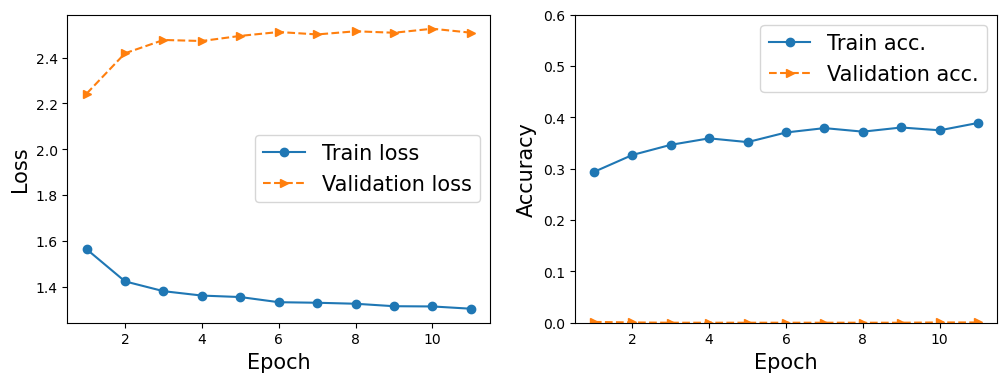

In [18]:
# Plot curves
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '-->', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '-->', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

In [ ]:
# Grid search for learning rate
df = pd.DataFrame(columns=['Param','Train Accuracy', 'Val Accuracy'])

learning_rate_list = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]

for i in range(len(learning_rate_list)):
    ffnn2 = build_ffnn_ad(num_features = X_train_std.shape[1], learning_rate=learning_rate_list[i])
    history = ffnn2.fit(x=X_train_std, y=y_train, epochs=150, batch_size=16, 
                        validation_split=0.1, verbose=0, callbacks = [es])
    
    df.loc[i,'Param'] = learning_rate_list[i]
    df.loc[i,'Train Accuracy'] = sum(history.history['accuracy'][-10:]) / 10
    df.loc[i,'Val Accuracy'] = sum(history.history['val_accuracy'][-10:]) / 10

df

In [ ]:
# Grid search for batch size
df = pd.DataFrame(columns=['Param','Train Accuracy', 'Val Accuracy'])

batch_size_list = [8,16,32,64]

for i in range(len(batch_size_list)):
    ffnn2 = build_ffnn_ad(num_features = X_train_std.shape[1], learning_rate=0.01)
    history = ffnn2.fit(x=X_train_std, y=y_train, epochs=150, batch_size=batch_size_list[i], 
                        validation_split=0.1, verbose=0, callbacks = [es])
    
    df.loc[i,'Param'] = batch_size_list[i]
    df.loc[i,'Train Accuracy'] = sum(history.history['accuracy'][-10:]) / 10
    df.loc[i,'Val Accuracy'] = sum(history.history['val_accuracy'][-10:]) / 10

df

In [ ]:
# Cross validation

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []

for train_index, test_index in kf.split(X):
    
#     # Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_cat_train, y_cat_test = y_cat[train_index], y_cat[test_index]
    
#     # Scaling your data
    scaler = StandardScaler()
    X_train_rescaled = scaler.fit_transform(X_train)
    X_test_rescaled = scaler.transform(X_test)
    
#     # Initialize the model

    model = initialize_model()

#     # Fit the model on the train data

    model.fit(X_train_rescaled, y_cat_train, batch_size=16, epochs=150)
    
#     # Evaluate the model on the test data

    results.append(model.evaluate(X_test_rescaled, y_cat_test))

## LSTM

In [22]:
def build_lstm_model(num_features, learning_rate):
    
    # Set-up
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    # Initialize model
    model_lstm = tf.keras.Sequential()
    
    # Input layer
    model_lstm.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    # add first lstm layer
    model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=200,
        #recurrent_dropout=0.4,
        #use_bias=True,
        return_sequences=True,
        name='LSTM1'), name='bidir-LSTM1'))    
    
    model_lstm.add(Dropout(
        rate=0.5,
        name='Dropout1'
    ))
    
    # add Dense layers
    model_lstm.add(Dense(
        units=64,
        activation='relu',
        name='Dense1'
    ))
    
    # create output layer
    model_lstm.add(tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax',
          name='Output'))
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, 
                                        momentum=0.3, nesterov=True)
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model

# Build model
lstm = build_lstm_model(num_features = X_train_std.shape[1], learning_rate=0.0025)
lstm.summary()

ValueError: Input 0 of layer "bidir-LSTM1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 81)